# Imports

In [1]:
from random_seed import seed_everything, RANDOM_SEED
seed_everything(RANDOM_SEED)

In [189]:
import hpsv2
import os
import optuna
import gc
import pickle
import shap

from functools import partial
from itertools import combinations  
from PIL import Image
import pandas as pd
import numpy as np

from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import mean_absolute_error, mean_squared_error, accuracy_score, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split

import torch
import lpips
from torchvision.transforms import ToTensor
from transformers import CLIPProcessor, CLIPModel
from transformers import AutoProcessor, AutoModel
from torchvision.models.optical_flow import Raft_Large_Weights, raft_large

from skimage.metrics import structural_similarity as ssim
from catboost import CatBoostRegressor, Pool
import matplotlib.pyplot as plt

# Preparation

In [228]:
with open('dict_with_features.pickle', 'rb') as f:
    dct = pickle.load(f)

In [61]:
num_frames = 100
models = list(dct.keys())

In [12]:
optuna.logging.set_verbosity(optuna.logging.ERROR)

# ML

## Data

In [5]:
df = pd.read_csv('feature_df.csv')

target_column = 'target'

feature_columns = df.columns.tolist()
not_features = ['prompt', 'target']

for not_feature in not_features:
    feature_columns.remove(not_feature)

In [16]:
X = df[feature_columns]
y = df[target_column]

# Разделение на квантили непрерывного таргета для стратификации
quantiles = np.percentile(y, range(0,110,10))
y_multiclass = np.digitize(y, quantiles[:-1], right=False)

# Порог для задачи бинарной классификации
threshold = 5.5

## Auxiliary Functions

In [31]:
# objective для задачи регрессии
def objective_rgr(trial, X_train, y_train, X_test, y_test):
    n_estimators = trial.suggest_int("n_estimators", 10, 500, log=True)
    max_depth = trial.suggest_int("max_depth", 2, 100)
    min_samples_split = trial.suggest_int("min_samples_split", 2, 10)
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 10)

    model = RandomForestRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        random_state=RANDOM_SEED,
        n_jobs=-1
    )
    
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    mae = mean_absolute_error(y_test, y_pred)

    return mae

# objective для задачи классификации
def objective_clf(trial, X_train, y_train, X_test, y_test):
    n_estimators = trial.suggest_int("n_estimators", 10, 500, log=True)
    max_depth = trial.suggest_int("max_depth", 2, 100)
    min_samples_split = trial.suggest_int("min_samples_split", 2, 10)
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 10)

    model = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        random_state=RANDOM_SEED,
        n_jobs=-1
    )
    
    model.fit(X_train, y_train_binary)
    y_pred = model.predict(X_test)

    accuracy = accuracy_score(y_test_binary, y_pred)

    return accuracy

In [180]:
def stratified_fit_predict(data, 
                           y, 
                           y_multiclass, 
                           features, 
                           experiment_logs, 
                           experiment_name, 
                           n_splits=5):
    """
    1) Получение гиперпараметров с помощью optuna для задач регрессии и классификации на признаках features
    2) Получение метрик MAE и Accuracy с помощью стратифицированной кросс-валидации с n_splits фолдами на гиперпараметрах из 1)
    3) Получение shap_values для кросс-валидации
    4) Сохранение всех логов в словарь experiment_logs с ключом experiment_name
    """
    X = data.copy()
    X = data[features]
    
    # Получение гиперпараметров для задачи регрессии и классификации с помощью optuna
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, 
        test_size=0.2, 
        stratify=y_multiclass, 
        random_state=RANDOM_SEED
    )
    
    y_train_binary = y_train < threshold
    y_test_binary = y_test < threshold
    
    scaler = StandardScaler()
    scaler.fit(X_train)
        
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)
    
    study_rgr = optuna.create_study(direction='minimize')
    objective = partial(objective_rgr, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test)
    study_rgr.optimize(objective, n_trials=50)
    print(f'Оптимальные параметры для регрессии: {study_rgr.best_params}')
    
    study_clf = optuna.create_study(direction='maximize')
    objective = partial(objective_clf, X_train=X_train, y_train=y_train_binary, X_test=X_test, y_test=y_test_binary)
    study_clf.optimize(objective, n_trials=50)
    print(f'Оптимальные параметры для классификации: {study_clf.best_params}')

    # После получения гиперпараметров, переход к стратифицированной кросс-валидации
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=RANDOM_SEED)
    
    shap_values_rgr_list = []
    shap_values_clf_list = []
    mae_list = []
    accuracy_list = []
    test_indexes = []
    
    for i, (train_index, test_index) in enumerate(skf.split(X, y_multiclass)):
        # Подготовка фолда
        X_train_fold = X.iloc[train_index]
        X_test_fold  = X.iloc[test_index]
        
        y_train_fold = y[train_index]
        y_test_fold = y[test_index]

        scaler = StandardScaler()
        scaler.fit(X_train_fold)

        X_train_fold = scaler.transform(X_train_fold)
        X_test_fold = scaler.transform(X_test_fold)

        # Обучение моделей на оптимальных гиперпараметрах
        # Регрессия
        best_rf_rgr = RandomForestRegressor(random_state=RANDOM_SEED, **study_rgr.best_params)
        best_rf_rgr.fit(X_train_fold, y_train_fold)
        
        y_pred = best_rf_rgr.predict(X_test_fold)
        mae_fold = mean_absolute_error(y_test_fold, y_pred)

        # Классификация
        y_train_fold_binary = y_train_fold < threshold
        y_test_fold_binary = y_test_fold < threshold
        
        best_rf_clf = RandomForestClassifier(random_state=RANDOM_SEED, **study_clf.best_params)
        best_rf_clf.fit(X_train_fold, y_train_fold_binary)
        
        y_pred = best_rf_clf.predict(X_test_fold)
        accuracy_fold = accuracy_score(y_test_fold_binary, y_pred)

        # Получение shap_values
        # Для регрессора
        explainer = shap.TreeExplainer(best_rf_rgr)
        shap_values_rgr_fold = explainer.shap_values(X_test)

        # Для классификатора
        explainer = shap.TreeExplainer(best_rf_clf)
        shap_values_clf_fold = explainer.shap_values(X_test)

        # Сохранение всех метрик и shap_values
        shap_values_rgr_list.append(shap_values_rgr_fold)
        shap_values_clf_list.append(shap_values_clf_fold)

        accuracy_list.append(accuracy_fold)
        mae_list.append(mae_fold)

        test_indexes.append(test_index)
        
    # сохранение всех логов    
    experiment_logs[experiment_name] = {
        'mae_list': mae_list,
        'accuracy_list': accuracy_list,
        'shap_rgr_list': shap_values_rgr_list,
        'shap_clf_list': shap_values_clf_list,
        'optimal_rgr': study_rgr.best_params,
        'optimal_clf': study_clf.best_params,
        'test_indexes': test_indexes
    }

## Feature_sets

In [138]:
aggregations = [
        'ema_01',
        'ema_03',
        'ema_05',
        'ema_07',
        'ema_09',
        'sum',
        'mean',
        'median',
        'std',
        'min',
        'max',
        'q_25',
        'q_75',
        'IQR',
        'min/max'
    ]

In [186]:
all_features = X.columns.tolist()
model_features = {}

for model in models:
    num_aggregated_features = 0 
    num_frames_features = 0

    model_features[model] = {
        'aggregated': [],
        'frames': [],
        'all': []
    }
    
    for feature in all_features:
        if model in feature:
            aggregated = False
            
            for aggregation in aggregations:
                if aggregation in feature:
                    aggregated = True
                    break
    
            if aggregated:
                num_aggregated_features += 1
                model_features[model]['aggregated'].append(feature)
                
            else:
                num_frames_features += 1
                model_features[model]['frames'].append(feature)
                
            model_features[model]['all'].append(feature)
    
    print(model)
    print(f'num aggregated features: {num_aggregated_features}')
    print(f'num frames features    : {num_frames_features}')   
    print(f"num all features       : {num_aggregated_features + num_frames_features}")
    print()

hps
num aggregated features: 15
num frames features    : 100
num all features       : 115

lpips
num aggregated features: 15
num frames features    : 100
num all features       : 115

ssim
num aggregated features: 15
num frames features    : 100
num all features       : 115

optical_flow
num aggregated features: 270
num frames features    : 0
num all features       : 270

clip-vit-base-patch32
num aggregated features: 15
num frames features    : 100
num all features       : 115

clip-vit-large-patch14
num aggregated features: 15
num frames features    : 100
num all features       : 115

siglip-so400m-patch14-384
num aggregated features: 15
num frames features    : 100
num all features       : 115

siglip-large-patch16-384
num aggregated features: 15
num frames features    : 100
num all features       : 115

jina-clip-v2
num aggregated features: 15
num frames features    : 100
num all features       : 115



In [203]:
# Словарь для хранения названий экспериментов и соответствующих наборов фичей
feature_sets = {}

# Модели, сравнивающие промпт и изображение
text_image_models = [
    'hps', 'jina-clip-v2', 
    'clip-vit-base-patch32', 'clip-vit-large-patch14', 
    'siglip-so400m-patch14-384', 'siglip-large-patch16-384', 
]

# Модели, сравнивающие изображения друг с другом
image_image_models = ['lpips', 'ssim', 'optical_flow']

# Тип фичей: агрегированные, полученные на фреймах, или все вместе
variations = ['aggregated', 'frames', 'all']

# Наборы дополнительных фичей
suffixes = ['only', 'l', 's', 'of', 'l_s', 'l_of', 's_of', 'l_s_of']

# Всевозможные фичи
feature_sets['all_features'] = X.columns.tolist()

# Только фичи с text_image_model
suffix = 'only'

for text_image_model in text_image_models:
    for variation in variations:
        feature_sets[f'{variation}_{text_image_model}_{suffix}'] = model_features[text_image_model][variation].copy()

# Фичи с text_image_model + агрегированные комбинации image_image_models (длины 1, 2 и 3)
for text_image_model in text_image_models:
    for variation in variations:
        image_image_models_combinations = [list(comb) for i in range(1, N + 1) for comb in combinations(image_image_models, i)]

        for image_image_models_combination in image_image_models_combinations:
            suffix = ''
            
            if 'lpips' in image_image_models_combination:
                suffix += 'l'

            if 'ssim' in image_image_models_combination:
                if len(suffix) == 0:
                    suffix += 's'
                else:
                    suffix += '_s'

            if 'optical_flow' in image_image_models_combination:
                if len(suffix) == 0:
                    suffix += 'of'
                else:
                    suffix += '_of'

            feature_sets[f'{variation}_{text_image_model}_{suffix}'] = model_features[text_image_model][variation].copy()

            for image_image_model in image_image_models_combination:
                # для image_image_model добавляем только агрегированные фичи
                feature_sets[f'{variation}_{text_image_model}_{suffix}'].extend(model_features[image_image_model]['aggregated'])

## Experiments

In [204]:
experiment_logs = {}

for experiment_name in feature_sets.keys():
    print('Feature set - ', experiment_name)
    
    features = feature_sets[experiment_name]

    stratified_fit_predict(
        data=X,
        y=y,
        y_multiclass=y_multiclass,
        features=features,
        experiment_logs=experiment_logs,
        experiment_name=experiment_name
    )

    accuracy_array = np.array(experiment_logs[experiment_name]['accuracy_list'])
    mae_array = np.array(experiment_logs[experiment_name]['mae_list'])

    accuracy_mean = accuracy_array.mean() * 100
    accuracy_std = accuracy_array.std() * 100
    mae_mean = mae_array.mean()
    mae_std = mae_array.std()
    
    experiment_logs[experiment_name]['accuracy_mean'] = accuracy_mean
    experiment_logs[experiment_name]['accuracy_std'] = accuracy_std
    experiment_logs[experiment_name]['mae_mean'] = mae_mean
    experiment_logs[experiment_name]['mae_std'] = mae_std
    
    print(f"Accuracy: {accuracy_mean:.2f} +- {accuracy_std:.2f}")
    print(f"MAE     : {mae_mean:.2f} +- {mae_std:.2f}")
    print()

Feature set -  all_features
Оптимальные параметры для регрессии: {'n_estimators': 40, 'max_depth': 83, 'min_samples_split': 8, 'min_samples_leaf': 3}
Оптимальные параметры для классификации: {'n_estimators': 10, 'max_depth': 95, 'min_samples_split': 10, 'min_samples_leaf': 8}
Accuracy: 67.00 +- 7.14
MAE     : 1.87 +- 0.18

Feature set -  aggregated_hps_only
Оптимальные параметры для регрессии: {'n_estimators': 57, 'max_depth': 23, 'min_samples_split': 8, 'min_samples_leaf': 7}
Оптимальные параметры для классификации: {'n_estimators': 55, 'max_depth': 26, 'min_samples_split': 2, 'min_samples_leaf': 1}
Accuracy: 61.50 +- 5.39
MAE     : 1.84 +- 0.19

Feature set -  frames_hps_only
Оптимальные параметры для регрессии: {'n_estimators': 10, 'max_depth': 85, 'min_samples_split': 5, 'min_samples_leaf': 4}
Оптимальные параметры для классификации: {'n_estimators': 12, 'max_depth': 51, 'min_samples_split': 6, 'min_samples_leaf': 5}
Accuracy: 59.00 +- 7.35
MAE     : 2.17 +- 0.06

Feature set -  al

In [233]:
dfs_rgr = {}
dfs_clf = {}

for variation in variations:
    dfs_rgr[variation] = {}
    dfs_clf[variation] = {}
    
    for suffix in suffixes:
        dfs_rgr[variation][suffix] = []
        dfs_clf[variation][suffix] = []
        
        for text_image_model in text_image_models:
            experiment_name = f"{variation}_{text_image_model}_{suffix}"

            dfs_rgr[variation][suffix].append(f"{experiment_logs[experiment_name]['mae_mean']:.2f} +- {experiment_logs[experiment_name]['mae_std']:.2f}")
            dfs_clf[variation][suffix].append(f"{experiment_logs[experiment_name]['accuracy_mean']:.2f} +- {experiment_logs[experiment_name]['accuracy_std']:.2f}")

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


## Results

* For classification - **accuracy**

In [234]:
pd.DataFrame(dfs_clf['all'], index=text_image_models)

,only,l,s,of,l_s,l_of,s_of,l_s_of
hps,66.50 +- 6.63,66.50 +- 6.44,69.00 +- 4.64,57.50 +- 9.87,73.00 +- 6.60,63.50 +- 8.00,58.00 +- 6.00,64.00 +- 3.74
jina-clip-v2,67.00 +- 8.57,67.50 +- 6.71,70.00 +- 4.47,64.50 +- 6.78,71.00 +- 3.39,66.50 +- 9.03,63.50 +- 8.15,69.50 +- 8.12
clip-vit-base-patch32,60.50 +- 2.45,64.00 +- 3.39,62.00 +- 4.00,55.00 +- 6.52,66.00 +- 4.06,61.00 +- 5.15,62.50 +- 10.84,64.00 +- 6.04
clip-vit-large-patch14,65.50 +- 6.20,66.50 +- 4.64,61.50 +- 6.04,63.50 +- 4.36,67.50 +- 4.18,63.00 +- 5.79,66.00 +- 5.15,63.50 +- 5.61
siglip-so400m-patch14-384,56.00 +- 6.63,62.50 +- 6.12,60.00 +- 4.18,58.50 +- 8.75,63.50 +- 6.44,56.00 +- 6.82,61.00 +- 7.18,60.00 +- 7.42
siglip-large-patch16-384,58.00 +- 4.85,62.00 +- 3.67,64.00 +- 6.63,61.50 +- 10.56,63.50 +- 6.04,64.50 +- 4.85,61.50 +- 8.60,65.00 +- 2.24


In [235]:
pd.DataFrame(dfs_clf['aggregated'], index=text_image_models)

,only,l,s,of,l_s,l_of,s_of,l_s_of
hps,61.50 +- 5.39,66.00 +- 6.82,64.00 +- 6.63,59.00 +- 5.39,67.50 +- 7.07,62.50 +- 6.71,58.00 +- 7.31,59.50 +- 4.30
jina-clip-v2,67.00 +- 3.32,66.50 +- 5.83,70.00 +- 6.32,57.00 +- 9.27,74.50 +- 4.85,64.50 +- 6.78,58.50 +- 8.46,60.50 +- 6.00
clip-vit-base-patch32,59.50 +- 1.87,67.50 +- 3.54,65.00 +- 6.12,59.00 +- 8.00,61.00 +- 3.00,61.50 +- 10.32,59.00 +- 6.04,61.50 +- 6.63
clip-vit-large-patch14,67.00 +- 7.48,72.50 +- 3.87,70.00 +- 3.16,60.00 +- 7.07,73.50 +- 4.36,64.00 +- 9.82,63.00 +- 11.34,63.00 +- 6.20
siglip-so400m-patch14-384,62.50 +- 3.54,64.00 +- 3.39,62.00 +- 5.79,58.50 +- 7.68,63.00 +- 7.31,58.50 +- 3.00,57.50 +- 9.87,61.50 +- 6.82
siglip-large-patch16-384,59.50 +- 2.92,65.00 +- 4.74,63.00 +- 2.92,56.00 +- 5.15,68.00 +- 5.10,57.50 +- 8.22,61.00 +- 3.00,62.50 +- 5.24


In [236]:
pd.DataFrame(dfs_clf['frames'], index=text_image_models)

,only,l,s,of,l_s,l_of,s_of,l_s_of
hps,59.00 +- 7.35,59.50 +- 7.97,69.50 +- 5.79,60.50 +- 12.39,73.00 +- 4.85,60.00 +- 10.61,61.00 +- 8.00,63.50 +- 10.32
jina-clip-v2,63.50 +- 7.35,66.50 +- 6.63,67.00 +- 6.20,62.50 +- 11.29,68.00 +- 4.85,59.50 +- 10.30,62.00 +- 9.27,65.50 +- 10.30
clip-vit-base-patch32,57.00 +- 2.92,61.50 +- 4.36,62.50 +- 4.47,54.50 +- 6.96,64.50 +- 4.85,60.00 +- 3.16,60.00 +- 10.84,58.00 +- 10.30
clip-vit-large-patch14,64.50 +- 5.10,66.00 +- 4.64,64.50 +- 4.30,60.50 +- 3.32,60.00 +- 7.58,58.50 +- 7.00,61.50 +- 7.68,58.50 +- 6.63
siglip-so400m-patch14-384,58.00 +- 5.79,56.50 +- 4.64,54.00 +- 9.30,61.50 +- 7.00,60.50 +- 6.60,63.00 +- 6.60,62.50 +- 11.83,60.00 +- 6.52
siglip-large-patch16-384,59.50 +- 6.78,63.50 +- 3.74,63.50 +- 5.15,60.00 +- 6.52,65.50 +- 1.87,65.00 +- 7.42,65.00 +- 6.32,64.50 +- 5.57


* For regression - **MAE**

In [237]:
pd.DataFrame(dfs_rgr['all'], index=text_image_models)

,only,l,s,of,l_s,l_of,s_of,l_s_of
hps,1.79 +- 0.18,1.81 +- 0.19,1.79 +- 0.16,1.96 +- 0.20,1.76 +- 0.15,1.96 +- 0.20,1.85 +- 0.16,1.87 +- 0.16
jina-clip-v2,1.89 +- 0.11,1.90 +- 0.10,1.77 +- 0.09,1.93 +- 0.17,1.79 +- 0.09,1.93 +- 0.17,1.84 +- 0.19,1.89 +- 0.18
clip-vit-base-patch32,1.83 +- 0.12,1.87 +- 0.15,1.84 +- 0.14,1.99 +- 0.14,1.87 +- 0.14,2.00 +- 0.14,1.91 +- 0.15,1.93 +- 0.16
clip-vit-large-patch14,1.82 +- 0.23,1.90 +- 0.16,1.81 +- 0.20,1.99 +- 0.18,1.83 +- 0.15,1.98 +- 0.14,1.89 +- 0.17,1.91 +- 0.15
siglip-so400m-patch14-384,2.02 +- 0.09,2.00 +- 0.11,1.85 +- 0.10,2.12 +- 0.13,1.85 +- 0.14,2.02 +- 0.15,1.92 +- 0.14,1.93 +- 0.14
siglip-large-patch16-384,2.16 +- 0.07,2.06 +- 0.07,1.85 +- 0.11,2.05 +- 0.19,1.87 +- 0.12,2.04 +- 0.15,1.94 +- 0.16,1.94 +- 0.15


In [238]:
pd.DataFrame(dfs_rgr['aggregated'], index=text_image_models)

,only,l,s,of,l_s,l_of,s_of,l_s_of
hps,1.84 +- 0.19,1.88 +- 0.22,1.78 +- 0.21,1.98 +- 0.19,1.77 +- 0.19,1.99 +- 0.18,1.88 +- 0.18,1.90 +- 0.16
jina-clip-v2,1.89 +- 0.07,1.88 +- 0.14,1.79 +- 0.11,1.95 +- 0.15,1.79 +- 0.10,1.95 +- 0.13,1.88 +- 0.15,1.87 +- 0.15
clip-vit-base-patch32,1.84 +- 0.14,1.93 +- 0.14,1.79 +- 0.19,1.99 +- 0.14,1.85 +- 0.16,1.97 +- 0.15,1.91 +- 0.16,1.92 +- 0.15
clip-vit-large-patch14,1.78 +- 0.19,1.88 +- 0.16,1.81 +- 0.22,1.96 +- 0.16,1.80 +- 0.15,1.96 +- 0.16,1.88 +- 0.17,1.92 +- 0.13
siglip-so400m-patch14-384,2.13 +- 0.09,2.05 +- 0.12,1.85 +- 0.15,2.02 +- 0.17,1.91 +- 0.17,2.03 +- 0.14,1.92 +- 0.14,1.95 +- 0.14
siglip-large-patch16-384,2.13 +- 0.09,2.15 +- 0.13,1.84 +- 0.11,2.08 +- 0.14,1.87 +- 0.12,2.03 +- 0.15,1.93 +- 0.15,1.94 +- 0.13


In [239]:
pd.DataFrame(dfs_rgr['frames'], index=text_image_models)

,only,l,s,of,l_s,l_of,s_of,l_s_of
hps,2.17 +- 0.06,2.11 +- 0.13,1.73 +- 0.14,1.98 +- 0.14,1.78 +- 0.11,1.97 +- 0.14,1.86 +- 0.15,1.87 +- 0.15
jina-clip-v2,2.03 +- 0.16,2.04 +- 0.14,1.78 +- 0.11,2.07 +- 0.13,1.82 +- 0.12,2.00 +- 0.16,1.88 +- 0.18,1.89 +- 0.16
clip-vit-base-patch32,2.18 +- 0.10,2.13 +- 0.10,1.99 +- 0.10,2.06 +- 0.12,1.90 +- 0.11,2.07 +- 0.11,1.96 +- 0.14,1.98 +- 0.14
clip-vit-large-patch14,2.10 +- 0.15,2.11 +- 0.14,1.91 +- 0.18,2.06 +- 0.13,1.88 +- 0.13,2.06 +- 0.12,1.95 +- 0.16,1.96 +- 0.14
siglip-so400m-patch14-384,2.11 +- 0.10,2.04 +- 0.17,1.89 +- 0.13,2.04 +- 0.14,1.91 +- 0.08,2.02 +- 0.14,1.93 +- 0.13,1.93 +- 0.12
siglip-large-patch16-384,2.20 +- 0.09,2.15 +- 0.13,1.84 +- 0.16,2.10 +- 0.20,1.87 +- 0.11,2.03 +- 0.15,1.94 +- 0.16,1.94 +- 0.16


## Best Models Analysis

In [259]:
%config InlineBackend.figure_formats = ['svg']
%matplotlib inline

* For classification - jina-clip-v2 on aggregated features with LPIPS and SSIM (**aggregated_jina-clip-v2_l_s**)

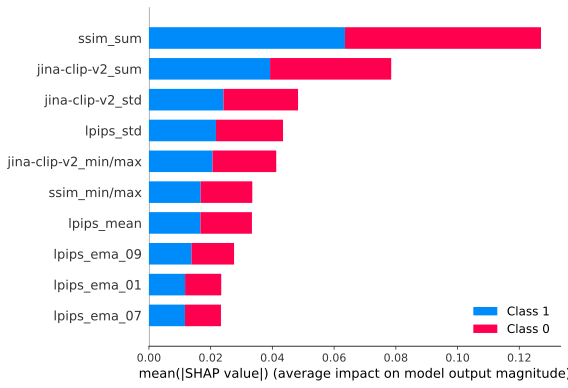

In [260]:
experiment_name = 'aggregated_jina-clip-v2_l_s'
features = feature_sets[experiment_name]

neg_class_arrays = [lst[0] for lst in experiment_logs[experiment_name]['shap_clf_list']]
pos_class_arrays = [lst[1] for lst in experiment_logs[experiment_name]['shap_clf_list']]

shap_values_clf = [np.vstack(neg_class_arrays), np.vstack(pos_class_arrays)]

new_index = [ix for ix_test_fold in experiment_logs[experiment_name]['test_indexes'] for ix in ix_test_fold]

# Визуализация
shap.summary_plot(shap_values_clf, X[features].reindex(new_index), feature_names=features, max_display=10)

* For regression - hps on frames features SSIM (**frames_hps_s**)

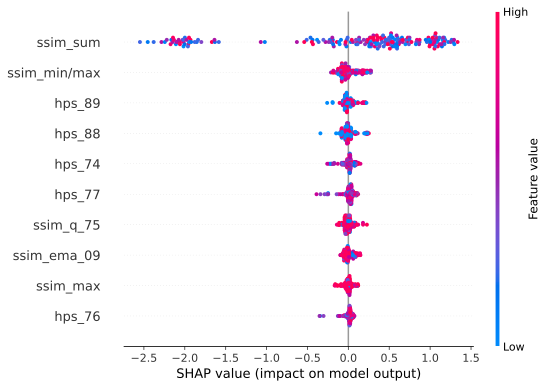

In [268]:
experiment_name = 'frames_hps_s'
features = feature_sets[experiment_name]

all_shap = experiment_logs[experiment_name]['shap_rgr_list']

shap_values = []
for shap_fold in all_shap:
    for shap_value in shap_fold:
        shap_values.append(shap_value)

new_index = [ix for ix_test_fold in experiment_logs[experiment_name]['test_indexes'] for ix in ix_test_fold]

# Визуализация
shap.summary_plot(np.array(shap_values), X[features].reindex(new_index), feature_names=features, max_display=10)